<a href="https://colab.research.google.com/github/kthom93/DeepLearning/blob/master/SNOM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using Siamese Networks

## Kevin Thompson

In [0]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import tqdm


from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from random import shuffle

In [0]:
class ObjectDataset(Dataset):
  def __init__(self, classes, transform=None):
    self.classes = classes
    self.num_classes = len(classes)
    self.tensor_transform = transforms.ToTensor()
  
  def __getitem__(self, index):
    same_class = np.random.randint(2)

    num = np.random.randint(num_classes)
    img1 = self.tensor_transform(self.classes[num][np.random.randint(len(self.classes[num]))])
    if not same_class:
      prev = num
      while(num == prev):
        num = np.random.randint(num_classes)
    img2 = self.tensor_transform(self.classes[num][np.random.randint(len(self.classes[num]))])

    return img1, img2, same_class
  
  def __len__(self):
    return len(self.classes[0] * self.num_classes)

In [0]:
class SiameseNetwork(nn.Module):
  def __init__(self, input_shape):
    super(SiameseNetwork, self).__init__()

    self.layer1 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(3, 24, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(24)
    )
    self.layer2 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(24, 48, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(48)
    )
    self.layer3 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(48, 96, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(96)
    )
    self.layer4 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(96, 48, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(48)
    )
    self.layer5 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(48, 24, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(24)
    )
    self.final = nn.Sequential(
        nn.Linear(24*input_shape[0]*input_shape[1], 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 500),
        nn.ReLU(inplace=True),
        nn.Linear(500, 20)
        # nn.Linear(500, 1)
    )


  def vectorize(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.view(out.size()[0], -1)
    out = self.final(out)
    return out

  def forward(self, x1, x2):
    out1 = self.vectorize(x1)
    out2 = self.vectorize(x2)
    # outc = torch.cat((out1, out2), 1)
    return out1, out2
    # return outc

In [0]:
class SimularityLoss(nn.Module):
  def __init__(self, margin=2.0):
    super(SimularityLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss = torch.mean((1-label) * torch.pow(distance, 2) + (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))

    return loss

In [0]:
def getEmptyClassList(dataset_len=10):
  classes = []
  for i in range(dataset_len):
    classes.append([])
  return classes

def loadClasses(data, num_classes, dataset_len=10):
  classes = getEmptyClassList(dataset_len)

  for im, c in data:
    classes[c].append(im)

  shuffle(classes)

  return classes[:num_classes]

In [0]:
def testModelNumbers(model, test_loader, num_classes=8, tests=100):
  data_iter = iter(test_loader)
  scores = [[],[]]
  for i in range(tests):
    img1, img2, label = next(data_iter)
    out1, out2 = model(img1.cuda(), img2.cuda())
    comb = torch.cat((img1, img2), 3).squeeze(0).numpy()
    comb = np.transpose(comb, (1,2,0))
    score = F.pairwise_distance(out1, out2)
    if label:
      scores[0].append(score.item())
    else:
      scores[1].append(score.item())
  return (sum(scores[1]) / len(scores[1])) - (sum(scores[0]) / len(scores[0]))
  # print('Same Scores Average: ' + str(sum(scores[0]) / len(scores[0])))
  # print('Different Scores Average: ' + str(sum(scores[1]) / len(scores[1])))


def testModelPictures(model, test_loader, num_classes=8, tests=10):
  data_iter = iter(test_loader)
  for i in range(tests):
    img1, img2, label = next(data_iter)
    out1, out2 = model(img1.cuda(), img2.cuda())
    comb = torch.cat((img1, img2), 3).squeeze(0).numpy()
    comb = np.transpose(comb, (1,2,0))
    score = F.pairwise_distance(out1, out2)
    plt.figure(figsize=(10,10))
    plt.imshow(comb)
    if label:
      addition = ' Same Class'
    else:
      addition = ' Different Class'
    plt.title('Dissimilarity Score: {:.2f}'.format(score.item()) + addition)

In [0]:
def scope(train_loader, val_loader, test_loader, num_classes, input_shape=(32,32), epochs=10, learning_rate=1e-4):
  model = SiameseNetwork(input_shape)
  objective = SimularityLoss()
  # objective = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  gc.collect()
  model.cuda()

  losses = []
  diffs = []

  loop = tqdm(total=(len(train_loader) * epochs), position=0, leave=False)
  for epoch in range(epochs):
    loss_per_epoch = []
    diff = 0
    diff = testModelNumbers(model, test_loader, num_classes)
    diffs.append(diff)
    for i, data in enumerate(train_loader):
      img1, img2, same_class = data
      img1, img2, same_class = img1.cuda(), img2.cuda(), same_class.cuda()
      
      optimizer.zero_grad()

      output1, output2 = model(img1, img2)
      loss = objective(output1, output2, same_class)
      # output = model(img1, img2)
      # loss = objective(output, same_class)
      loss.backward()
      optimizer.step()
      loop.set_description('Epoch:{}, Loss:{:.4f}, Diff:{:.4f}'.format(epoch, loss.item(), diff))
      loop.update(1)
      loss_per_epoch.append(loss.item())
    losses.append(sum(loss_per_epoch) / len(loss_per_epoch))
  plt.plot(losses)
  plt.title('Training Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(diffs)
  plt.title('Training Difference')
  plt.xlabel('Epochs')
  plt.ylabel('Difference')
  plt.show()

  return model

In [0]:
def cifar10Loaders(batch_size, num_classes):
  cifar10_train_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10/training/', train=True, download=True)
  cifar10_val_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10/testing/', train=False, download=True)

  train_classes = loadClasses(cifar10_train_dataset, num_classes)
  val_classes = loadClasses(cifar10_val_dataset, num_classes)

  train_dataset = ObjectDataset(train_classes)
  val_dataset = ObjectDataset(val_classes)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True)
  val_loader = DataLoader(val_dataset,
                          batch_size=batch_size)
  test_loader = DataLoader(train_dataset,
                          batch_size=1,
                          shuffle=True)
  return train_loader, val_loader, test_loader

def imageNetLoaders(batch_size, num_classes):
  image_net_train_dataset = torchvision.datasets.ImageNet(root='./data/imageNet/training/', split='train', download=True)
  image_net_val_dataset = torchvision.datasets.ImageNet(root='./data/imageNet/testing/', split='val', download=True)

  image_net_train_dataset[0]

def STL10Loaders(batch_size, num_classes):
  STL10_train_dataset = torchvision.datasets.STL10(root='./data/STL10/training/', split='train', download=True)
  STL10_dataset = torchvision.datasets.STL10(root='./data/STL10/testing/', split='test', download=True)

  STL10_train_dataset[0]

In [0]:
# STL10Loaders(batch_size, num_classes)

In [0]:
batch_size = 128
num_classes = 8

train_loader, val_loader, test_loader = cifar10Loaders(batch_size, num_classes)

Extracting ./data/cifar10/training/cifar-10-python.tar.gz to ./data/cifar10/training/


Extracting ./data/cifar10/testing/cifar-10-python.tar.gz to ./data/cifar10/testing/




Epoch:99, Loss:1.0450, Diff:0.0341: 100%|█████████▉| 31299/31300 [53:14<00:00, 10.11it/s]

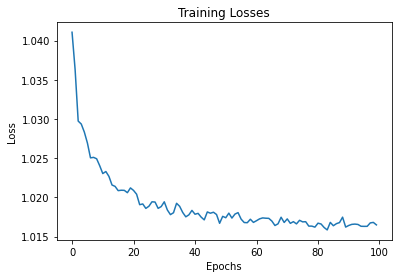

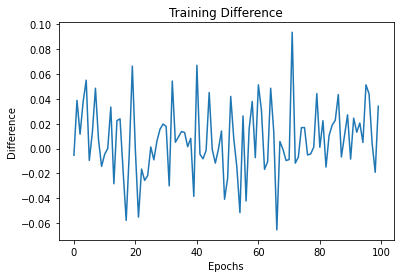

In [0]:
model1 = scope(train_loader, val_loader, test_loader, num_classes, epochs=100)

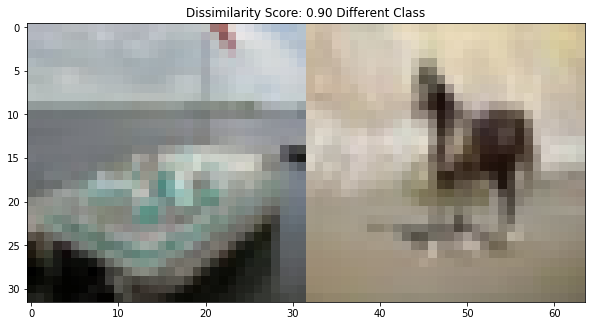

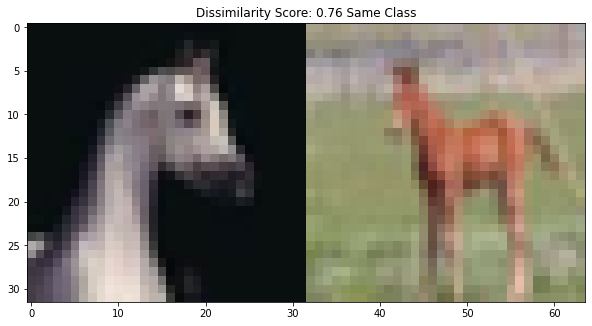

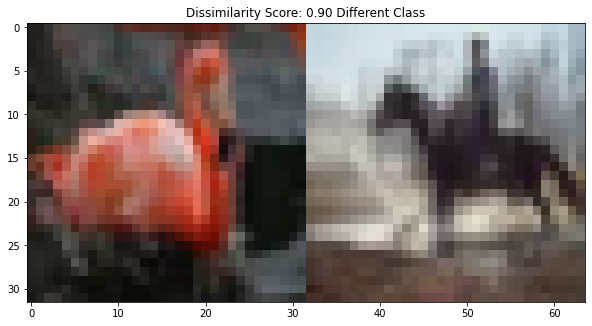

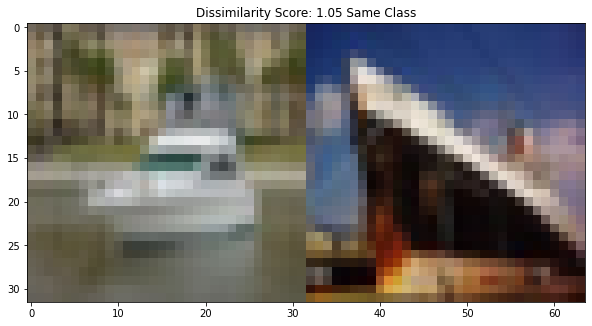

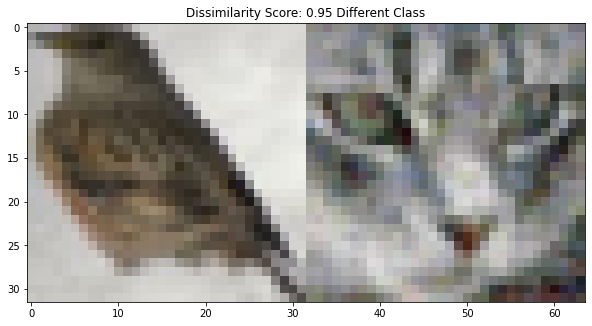

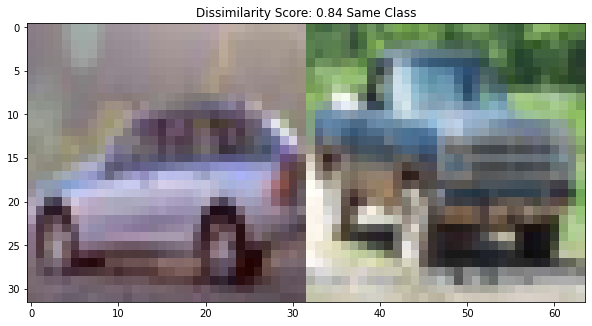

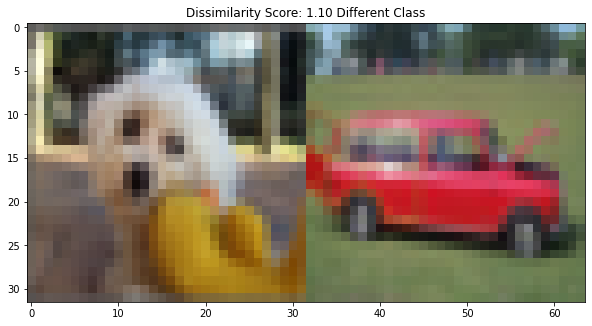

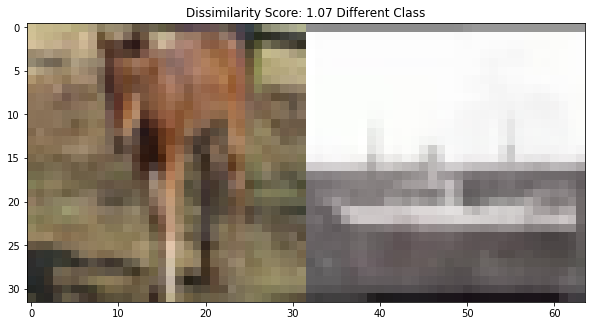

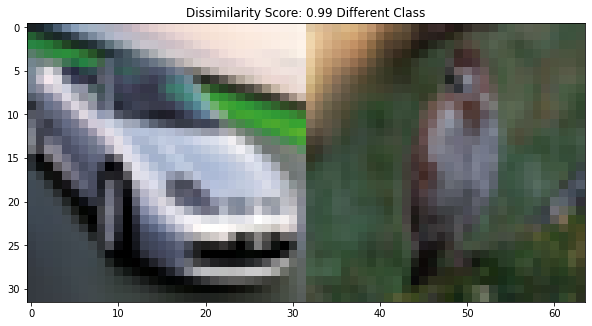

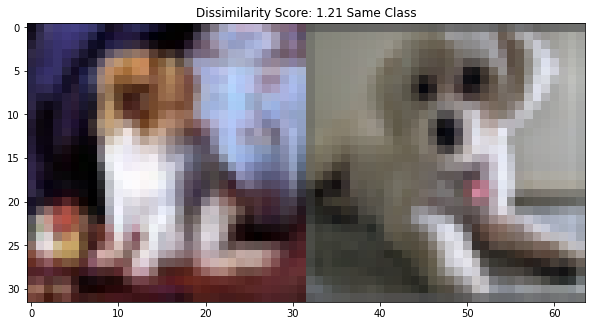

In [0]:
testModelNumbers(model1, test_loader, num_classes=2, tests=1000)
testModelPictures(model1, test_loader, num_classes=2, tests=10)

In [0]:
def createObjectVectorDatabase(num_classes=8, ):
